# Pose Comparison BPD - Test

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import math
import socket
import time
import os

In [26]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPracticeThree.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (0, 6): 'm',
    (0, 5): 'm',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,2],
    [1,3],
    [2,4],
    [3,5],
    [4,6],
    [1,7],
    [2,8],
    [7,8],
    [7,9],
    [8,10],
    [9,11],
    [10,12]
]
# vectorList = [
#     [0,1],
#     [0,2],
#     [1,3],
#     [2,4],
#     [3,5],
#     [0,6],
#     [1,7],
#     [6,7],
#     [6,8],
#     [7,9],
#     [8,10],
#     [9,11]
# ]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 10)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 3
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(actionPractice)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,len(vectorList),3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

[0.04078047 0.01142499 0.0338895  0.02559673 0.02357918 0.06814274
 0.05066196 0.00242202 0.010996   0.0767194  0.00322227 0.01452897
 0.00679296 0.02197797]
[0.03729244 0.0129967  0.03407601 0.02023629 0.01388831 0.03603637
 0.042843   0.0009035  0.00844544 0.07909203 0.00286806 0.01436795
 0.00624047 0.02226045]
[0.0342039  0.01613776 0.03512279 0.01736819 0.01605524 0.03824752
 0.04164358 0.00203751 0.00969988 0.08110584 0.00302185 0.01560121
 0.00630164 0.02529486]
[0.0433015  0.01484822 0.03292804 0.02556042 0.02102662 0.03364595
 0.05072204 0.00231891 0.01205108 0.07628979 0.00240244 0.01902263
 0.00607484 0.02697505]
[0.04174236 0.01796958 0.02989171 0.02359242 0.01375748 0.03872231
 0.05545967 0.00268051 0.01141922 0.06917577 0.00313631 0.01746574
 0.00532554 0.02623339]
[0.04004576 0.01676662 0.0308168  0.02245354 0.01880031 0.02600306
 0.04735038 0.00213312 0.01085132 0.07524036 0.00305064 0.01440201
 0.00468169 0.02403738]
[0.0414121  0.01349291 0.03022936 0.02434484 0.02195

[0.02165181 0.00736636 0.03005536 0.02258261 0.01296984 0.01199356
 0.02684714 0.00226344 0.00711073 0.03165483 0.0031038  0.00957142
 0.00687611 0.01801019]
[0.01894142 0.01211071 0.03249134 0.01594296 0.01941713 0.01140573
 0.03295114 0.00478941 0.00839746 0.06404828 0.00355127 0.0082181
 0.00558736 0.01663705]
[0.02301869 0.01152837 0.03461992 0.01687634 0.01545756 0.00968228
 0.0246006  0.00417578 0.00803975 0.06321764 0.00450853 0.00752633
 0.00642418 0.01543299]
[0.02952042 0.01161049 0.02782525 0.02348316 0.01397649 0.00339889
 0.02606043 0.0024565  0.00761748 0.06546883 0.00332805 0.00975864
 0.00484535 0.01569587]
[0.02406803 0.00966615 0.02630654 0.02502849 0.01778007 0.00858976
 0.02241253 0.00219647 0.00802302 0.06307488 0.00460271 0.00920202
 0.00465991 0.01370646]
[0.02485845 0.00884235 0.0304781  0.0242246  0.02167261 0.00828917
 0.02910507 0.00145854 0.00782583 0.06574827 0.00493544 0.00884116
 0.00483256 0.01519696]
[0.02447698 0.00658859 0.03163305 0.021845   0.018936

[0.01836608 0.00624329 0.03043646 0.00512748 0.01749378 0.01671283
 0.04057247 0.00447068 0.00667301 0.02086254 0.00054165 0.0127594
 0.01357633 0.01775295]
[0.01508456 0.0054629  0.03247327 0.01611384 0.01387062 0.01531976
 0.04336491 0.00454936 0.00725617 0.02865011 0.00296298 0.01136701
 0.01245687 0.01592919]
[0.01464398 0.00208179 0.03151632 0.00942854 0.01458301 0.02794919
 0.04162691 0.00482342 0.00797481 0.03353436 0.00415165 0.01237278
 0.01589449 0.01464394]
[0.01609818 0.00888767 0.03395891 0.01162505 0.01752718 0.02323511
 0.03197784 0.00551796 0.00750974 0.0371607  0.00503562 0.01434526
 0.01478733 0.01798809]
[0.01792695 0.01330788 0.03209889 0.01419828 0.01978539 0.02012503
 0.03552696 0.0057596  0.00686308 0.03992192 0.00459063 0.01341154
 0.01668833 0.01880429]
[0.01668059 0.00854349 0.03754755 0.01883262 0.02228669 0.01561382
 0.03313294 0.00594917 0.00702538 0.03107663 0.00550897 0.0141759
 0.01765415 0.01824268]
[0.02235728 0.00638353 0.03919651 0.01133322 0.0187866

[0.09371308 0.18832872 0.22719502 0.87525841 0.16916126 0.0991305
 0.14503812 0.01796847 0.06059459 0.06606383 0.31390489 0.02498427
 0.24234503 0.00825259]
[0.14094011 0.16588797 0.25618693 0.28415102 0.02945704 0.13804011
 0.84898963 0.04524872 0.02561    0.07995557 0.18130674 0.03665533
 0.13096435 0.09562046]
[0.17218518 0.03411901 0.53117269 0.04745711 0.06677121 0.13153057
 0.64943441 0.01163622 0.04383209 0.41984433 0.22826626 0.01421439
 0.15676245 0.03279633]
[0.24666161 0.06095505 0.69600724 0.05227841 0.66856887 0.07175399
 0.53920165 0.02909222 0.03238475 0.86319763 0.18334321 0.1052198
 0.08893139 0.07283667]
[0.13818999 0.03204055 0.27126826 0.15696922 0.03413068 0.09122134
 0.6804248  0.01872201 0.0230398  0.880614   0.12940362 0.12978307
 0.06324088 0.10338882]
[0.14851245 0.04714982 0.34329956 0.22594651 0.13109355 0.2233765
 0.10651086 0.03332009 0.01014875 0.47305874 0.05835142 0.06079589
 0.01704786 0.10724095]
[0.26646036 0.04470662 0.71188074 0.26950224 0.17782421

[0.29644694 0.08333942 0.388645   0.0263646  0.81385197 0.67289766
 0.10466598 0.07277971 0.01730681 0.02091312 0.03850361 0.01993702
 0.58019737 0.02513979]
[0.27650302 0.01249    0.60940917 0.0150144  0.49364193 0.43614342
 0.01785975 0.05430251 0.0416911  0.02952126 0.05125817 0.03198376
 0.28459666 0.00254956]
[0.24657087 0.10848348 0.44944296 0.08983951 0.30033761 0.83219251
 0.24686391 0.04081532 0.02045668 0.09047518 0.03275731 0.01843734
 0.13104492 0.02923623]
[0.0653198  0.09762319 0.27707205 0.82339681 0.10638833 0.88925633
 0.10601953 0.03075164 0.00814346 0.05951579 0.03544067 0.02732068
 0.01183184 0.03587298]
[0.22170499 0.16906952 0.60853878 0.77995825 0.01261327 0.89576543
 0.07826996 0.00551358 0.03854293 0.0750647  0.01520908 0.00986455
 0.09404369 0.03478963]
[0.19045225 0.02490927 0.59232593 0.14117668 0.09605189 0.70394052
 0.03864581 0.00800455 0.06680718 0.09085504 0.04792302 0.02004026
 0.12976211 0.01077903]
[0.19710691 0.05822618 0.51227197 0.19103123 0.19095

[0.33799023 0.40107169 0.25919914 0.6293038  0.78827097 0.3615603
 0.49345182 0.05537675 0.01643496 0.01714979 0.04500036 0.03751739
 0.05626401 0.03495193]
[0.04992631 0.44931005 0.73952849 0.6051738  0.27664735 0.27648536
 0.31384042 0.10059208 0.04866656 0.04195213 0.03650177 0.06683491
 0.03670897 0.04380778]
[0.04891056 0.31851084 0.83975864 0.57592837 0.77057976 0.42674407
 0.64933176 0.08556274 0.01323731 0.19111972 0.01668915 0.07355599
 0.03193916 0.05413555]
[0.01199518 0.14017691 0.78070105 0.45321392 0.66512262 0.69898889
 0.74647213 0.0710127  0.00478286 0.11617309 0.00544054 0.09399959
 0.00491753 0.01291802]
[0.13815755 0.05255111 0.49834984 0.7772184  0.82553411 0.85562573
 0.83933864 0.02433139 0.03026298 0.16843953 0.01157791 0.06848688
 0.04720063 0.08289087]
[0.11828685 0.24015551 0.48487403 0.78149161 0.85302458 0.76897821
 0.82312822 0.0339212  0.01510697 0.05741878 0.07638638 0.07221169
 0.10185583 0.09921345]
[0.0698605  0.42214771 0.14566424 0.71426858 0.475311

[0.05112404 0.00358417 0.08268045 0.29233872 0.11493837 0.54861925
 0.71822124 0.02503824 0.00860168 0.03135386 0.01184775 0.02373777
 0.01217477 0.01612322]
[0.00840121 0.02772206 0.02714607 0.26048884 0.32658027 0.37245101
 0.86556223 0.01881396 0.00699629 0.02728621 0.01198263 0.02680042
 0.05024871 0.03898408]
[0.00510242 0.05183932 0.03170625 0.45780044 0.47327196 0.5824865
 0.73276353 0.0015411  0.01083789 0.06816807 0.04715192 0.05846141
 0.08076017 0.08510445]
[0.02852735 0.06050921 0.0527122  0.55003864 0.46910351 0.72596179
 0.65297305 0.01108845 0.0197573  0.07534769 0.05340794 0.10511323
 0.10642814 0.11028217]
[0.03468693 0.04936073 0.01890441 0.50756043 0.45644245 0.79165004
 0.79294677 0.01160098 0.01156983 0.01394111 0.08237453 0.12076039
 0.11080523 0.1629006 ]
[0.0608669  0.04244862 0.0225349  0.47628432 0.41397411 0.79864768
 0.83765114 0.01492863 0.01433705 0.02737218 0.097239   0.12871147
 0.10182668 0.17862283]
[0.02150982 0.03061963 0.0161292  0.37284522 0.352793

# Pose Compare BPD

In [ ]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
actionPractice = video_path + 'actionPracticeThree.mp4'


### Draw NEW_EDGES
NEW_EDGES = {
    (0, 6): 'm',
    (0, 5): 'm',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,2],
    [1,3],
    [2,4],
    [3,5],
    [4,6],
    [1,7],
    [2,8],
    [7,8],
    [7,9],
    [8,10],
    [9,11],
    [10,12]
]


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 10)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 3
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(actionPractice)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,len(vectorList),3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Score Representation: Concert (with recording video)

In [6]:
from PIL import Image

### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
actionPractice = video_path + 'actionPracticeWhite.mp4'

### Set the size of Load Image
im_height = 1080
im_width = 1980

# Load Pose_Hand_Images with Array
concert_list = []
path = '../../data/material/concert/'
fileType = '.png'
fileList = os.listdir(path)
fileList.sort()
for i in range(0, 5):
    original = Image.open(path + 'level' + str(i) + fileType)
    concert_list.append(original.resize((im_width, im_height), Image.ANTIALIAS))


### Draw NEW_EDGES
NEW_EDGES = {
    (0, 6): 'm',
    (0, 5): 'm',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,2],
    [1,3],
    [2,4],
    [3,5],
    [4,6],
    [1,7],
    [2,8],
    [7,8],
    [7,9],
    [8,10],
    [9,11],
    [10,12]
]


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 10)


### Variables for Calculating FPS
prevTime = time.time() # previous time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 3
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(actionPractice)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Resize the Concert PNG
        # Resize the PNG image to fit the frame
#         resized_png = cv2.resize(level_1, (frame.shape[1], frame.shape[0]))
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,len(vectorList),3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Overlay the PNG image on the video
        displaySensitivity = 5
        level = (np.mean(BPD) * 100) / displaySensitivity
        if level > 4:
            level = 4
        level = 4 - level
        pilim = Image.fromarray(frame)
        pilim.paste(concert_list[int(level)], box=(0, 0), mask=concert_list[int(level)])
        frame = np.array(pilim)
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)
        
        # Print Average BPD
        text_with_averageBPD = "Avg BPD Value: " + "{:.2f}".format(np.mean(BPD) * 100)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 100)
        cv2.putText(frame, text_with_averageBPD, location, font, 1, (0, 255, 0), 2)
        
        # Print Level
        ratings = ("BAD", "POOR", "FAIR", "GOOD", "EXCELLENT")
        text_with_level = "Level: " + ratings[int(level)]
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 150)
        cv2.putText(frame, text_with_level, location, font, 1, (0, 255, 0), 2)
        
        ### Calculate & Print FPS
        # Count Frame
        curTime = time.time()	# current time
        fps = 1 / (curTime - prevTime)
        prevTime = curTime
        # Save FPS
        fps_str = "FPS : %0.1f" %fps
        # FPS print
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 200)
        cv2.putText(frame, fps_str, location, font, 1, (0, 255, 0), 2)
                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

# Score Representation: Score (with video call)

In [2]:
from PIL import Image

### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

# ### Load Video
# video_path = '../../data/videos/'
# actionPractice = video_path + 'actionPracticeWhite.mp4'

### Set the size of Load Image
im_height = 1080
im_width = 1980

# Load Pose_Hand_Images with Array
concert_list = []
path = '../../data/material/concert/'
fileType = '.png'
fileList = os.listdir(path)
fileList.sort()
for i in range(0, 5):
    original = Image.open(path + 'level' + str(i) + fileType)
    concert_list.append(original.resize((im_width, im_height), Image.ANTIALIAS))


### Draw NEW_EDGES
NEW_EDGES = {
    (0, 6): 'm',
    (0, 5): 'm',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,2],
    [1,3],
    [2,4],
    [3,5],
    [4,6],
    [1,7],
    [2,8],
    [7,8],
    [7,9],
    [8,10],
    [9,11],
    [10,12]
]


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 10)


###


### Variables for Calculating FPS
prevTime = time.time() # previous time

if __name__ == "__main__":
    ### Variables
    numberOfPeople = 3
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(0)    ### Change the File Here!!
    # Variables for set the cam size
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1980)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
    
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Resize the Concert PNG
        # Resize the PNG image to fit the frame
#         resized_png = cv2.resize(level_1, (frame.shape[1], frame.shape[0]))
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,len(vectorList),3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Overlay the PNG image on the video
        displaySensitivity = 5
        level = (np.mean(BPD) * 100) / displaySensitivity
        if level > 4:
            level = 4
        level = 4 - level
        pilim = Image.fromarray(frame)
        pilim.paste(concert_list[int(level)], box=(0, 0), mask=concert_list[int(level)])
        frame = np.array(pilim)
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)
        
        # Print Average BPD
        text_with_averageBPD = "Avg BPD Value: " + "{:.2f}".format(np.mean(BPD) * 100)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 100)
        cv2.putText(frame, text_with_averageBPD, location, font, 1, (0, 255, 0), 2)
        
        # Print Level
        ratings = ("BAD", "POOR", "FAIR", "GOOD", "EXCELLENT")
        text_with_level = "Level: " + ratings[int(level)]
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 150)
        cv2.putText(frame, text_with_level, location, font, 1, (0, 255, 0), 2)
        
        ### Calculate & Print FPS
        # Count Frame
        curTime = time.time()	# current time
        fps = 1 / (curTime - prevTime)
        prevTime = curTime
        # Save FPS
        fps_str = "FPS : %0.1f" %fps
        # FPS print
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 200)
        cv2.putText(frame, fps_str, location, font, 1, (0, 255, 0), 2)
                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

C:\Users\LeeSooHwan\AppData\Local\Temp\ipykernel_45276\2271088920.py:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  concert_list.append(original.resize((im_width, im_height), Image.ANTIALIAS))


[0.12846801 0.14010377 0.03492262 0.21619823 0.09314717 0.46563859
 0.22063233 0.10124071 0.08235843 0.02126645 0.83240399 0.51991584
 0.16950742 0.2080412 ]
[0.48720267 0.07224252 0.71110015 0.67816523 0.42965711 0.62024143
 0.61555878 0.24370837 0.45445074 0.65212065 0.36238591 0.45627347
 0.27110233 0.54193924]
[0.07625035 0.11575911 0.03472254 0.15054159 0.06234813 0.23835413
 0.4307186  0.18234338 0.18211757 0.03335841 0.12828586 0.4557983
 0.11737364 0.24935528]
[0.04761197 0.1181462  0.03334691 0.20515209 0.02851295 0.35490155
 0.1736283  0.07983626 0.19048524 0.005898   0.87316629 0.02167774
 0.15457354 0.09065761]
[0.00602117 0.11447078 0.06811133 0.32381753 0.02159564 0.30630883
 0.0869727  0.05625591 0.31296675 0.02470252 0.66561171 0.08514458
 0.12309706 0.09700707]
[0.09233112 0.12792369 0.04371022 0.17691537 0.01676774 0.34097037
 0.12872109 0.18741827 0.3434765  0.0123564  0.8798548  0.01161764
 0.14043304 0.12063859]
[0.03369028 0.10513907 0.04766046 0.2408893  0.011315

[0.12419475 0.09491807 0.00603015 0.73451073 0.9212533  0.18807068
 0.88913851 0.50884824 0.70196286 0.27560515 0.28137799 0.86019118
 0.31326158 0.33402203]
[0.13847199 0.10246058 0.00681932 0.74982985 0.91641784 0.28883868
 0.53468979 0.53039017 0.73075997 0.24105878 0.29680622 0.86565618
 0.14842934 0.35449098]
[0.15002026 0.87783681 0.38089129 0.77598869 0.88107506 0.17737148
 0.87811495 0.38083601 0.44598902 0.29686624 0.39325527 0.88788696
 0.20074542 0.3120937 ]
[0.11746737 0.88425571 0.40510636 0.69747233 0.84587209 0.02931231
 0.89167514 0.43127209 0.51629667 0.28071978 0.33957609 0.83379495
 0.40673845 0.26738461]
[0.10599858 0.84420897 0.39541943 0.59114141 0.859755   0.08246335
 0.53876897 0.69110964 0.0801018  0.38021757 0.47457002 0.26644685
 0.20435545 0.37599226]
[0.05310962 0.03177404 0.01755288 0.59624719 0.57254581 0.85700937
 0.11737058 0.47080239 0.52262171 0.05296873 0.38640929 0.23925478
 0.10999026 0.44411305]
[0.05125119 0.02671337 0.01265067 0.26781525 0.37158

[0.19355356 0.62040505 0.86456414 0.80457329 0.67195465 0.35992313
 0.6707907  0.18857007 0.3260264  0.35366189 0.73218211 0.61980898
 0.84992747 0.91908038]
[0.025949   0.08603771 0.10220437 0.11416301 0.02812451 0.56439623
 0.08054335 0.05006389 0.13863898 0.00975997 0.87856752 0.26674126
 0.06377679 0.17395827]
[0.0358207  0.27601694 0.04338339 0.11323662 0.02206718 0.02261239
 0.02191496 0.08715546 0.21707161 0.0372051  0.92050301 0.72343781
 0.1351168  0.15072509]
[0.01257909 0.13237974 0.01631159 0.0768384  0.10184642 0.38254822
 0.42171688 0.168928   0.20349452 0.00286468 0.57362007 0.33552166
 0.06818498 0.05770387]
[0.08549824 0.17110533 0.21417253 0.24790993 0.21299343 0.1938651
 0.83169787 0.15881451 0.24977448 0.37008619 0.8488927  0.83172951
 0.09848464 0.15194312]
[0.11963304 0.12868249 0.11631149 0.26652752 0.27204614 0.63954847
 0.05207125 0.15797907 0.05312664 0.16038785 0.02710986 0.22876239
 0.10121698 0.27903281]
[0.0401394  0.05165832 0.04215613 0.20258107 0.114360

[0.08353546 0.10970029 0.02322403 0.18796074 0.15312466 0.42293043
 0.3756776  0.06502035 0.26402563 0.06520373 0.55069191 0.19485866
 0.15965305 0.23675607]
[0.54393974 0.42995362 0.74842335 0.82456301 0.58295233 0.67914918
 0.83969929 0.148623   0.39521129 0.78462709 0.82696083 0.62526102
 0.20902787 0.43284123]
[0.10496309 0.04282043 0.10039423 0.16752259 0.19698824 0.39582908
 0.25765018 0.23606116 0.29663526 0.08189613 0.68740043 0.14579195
 0.09966119 0.25073217]
[0.14003424 0.06624436 0.16303425 0.23450773 0.05731828 0.49963821
 0.24308809 0.12062183 0.18493451 0.07561294 0.81987918 0.88856155
 0.095325   0.13067345]
[0.16520109 0.04693543 0.21521178 0.24927896 0.09900144 0.51943199
 0.03831638 0.18872705 0.16218448 0.03993026 0.89015264 0.71481157
 0.18251565 0.17917781]
[0.14632141 0.12713599 0.07865834 0.1919617  0.17654257 0.34535308
 0.07523074 0.20048592 0.29109133 0.03130302 0.8435867  0.03789927
 0.12655305 0.18947909]
[0.18774104 0.1195883  0.04493241 0.20289169 0.08097

# Save BPD as CSV

In [4]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pandas as pd
import csv

In [8]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
actionPractice = video_path + 'actionPracticeThree.mp4'


### Draw NEW_EDGES
NEW_EDGES = {
    (0, 6): 'm',
    (0, 5): 'm',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,2],
    [1,3],
    [2,4],
    [3,5],
    [4,6],
    [1,7],
    [2,8],
    [7,8],
    [7,9],
    [8,10],
    [9,11],
    [10,12]
]


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 10)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 3
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []
    saveBPD = pd.DataFrame(columns=[str(i) for i in range(len(vectorList))])

    ### Loading Video File
    cap = cv2.VideoCapture(actionPractice)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,len(vectorList),3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        ### Save each BPD at the saveBPD for CSV saving
        saveBPD = pd.concat([saveBPD, pd.DataFrame([BPD], columns=saveBPD.columns)], ignore_index=True)
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            # Save the csv from the dataframe(saveBPD)
            saveBPD.to_csv('../../data/csv/BPD_actionPracticeThree.csv', index=False)
            break
    
    cap.release()
    cv2.destroyAllWindows()

[0.04078047 0.01142499 0.0338895  0.02559673 0.02357918 0.06814274
 0.05066196 0.00242202 0.010996   0.0767194  0.00322227 0.01452897
 0.00679296 0.02197797]
[0.03729244 0.0129967  0.03407601 0.02023629 0.01388831 0.03603637
 0.042843   0.0009035  0.00844544 0.07909203 0.00286806 0.01436795
 0.00624047 0.02226045]
[0.0342039  0.01613776 0.03512279 0.01736819 0.01605524 0.03824752
 0.04164358 0.00203751 0.00969988 0.08110584 0.00302185 0.01560121
 0.00630164 0.02529486]
[0.0433015  0.01484822 0.03292804 0.02556042 0.02102662 0.03364595
 0.05072204 0.00231891 0.01205108 0.07628979 0.00240244 0.01902263
 0.00607484 0.02697505]
[0.04174236 0.01796958 0.02989171 0.02359242 0.01375748 0.03872231
 0.05545967 0.00268051 0.01141922 0.06917577 0.00313631 0.01746574
 0.00532554 0.02623339]
[0.04004576 0.01676662 0.0308168  0.02245354 0.01880031 0.02600306
 0.04735038 0.00213312 0.01085132 0.07524036 0.00305064 0.01440201
 0.00468169 0.02403738]
[0.0414121  0.01349291 0.03022936 0.02434484 0.02195

[0.02165181 0.00736636 0.03005536 0.02258261 0.01296984 0.01199356
 0.02684714 0.00226344 0.00711073 0.03165483 0.0031038  0.00957142
 0.00687611 0.01801019]
[0.01894142 0.01211071 0.03249134 0.01594296 0.01941713 0.01140573
 0.03295114 0.00478941 0.00839746 0.06404828 0.00355127 0.0082181
 0.00558736 0.01663705]
[0.02301869 0.01152837 0.03461992 0.01687634 0.01545756 0.00968228
 0.0246006  0.00417578 0.00803975 0.06321764 0.00450853 0.00752633
 0.00642418 0.01543299]
[0.02952042 0.01161049 0.02782525 0.02348316 0.01397649 0.00339889
 0.02606043 0.0024565  0.00761748 0.06546883 0.00332805 0.00975864
 0.00484535 0.01569587]
[0.02406803 0.00966615 0.02630654 0.02502849 0.01778007 0.00858976
 0.02241253 0.00219647 0.00802302 0.06307488 0.00460271 0.00920202
 0.00465991 0.01370646]
[0.02485845 0.00884235 0.0304781  0.0242246  0.02167261 0.00828917
 0.02910507 0.00145854 0.00782583 0.06574827 0.00493544 0.00884116
 0.00483256 0.01519696]
[0.02447698 0.00658859 0.03163305 0.021845   0.018936

[0.01836608 0.00624329 0.03043646 0.00512748 0.01749378 0.01671283
 0.04057247 0.00447068 0.00667301 0.02086254 0.00054165 0.0127594
 0.01357633 0.01775295]
[0.01508456 0.0054629  0.03247327 0.01611384 0.01387062 0.01531976
 0.04336491 0.00454936 0.00725617 0.02865011 0.00296298 0.01136701
 0.01245687 0.01592919]
[0.01464398 0.00208179 0.03151632 0.00942854 0.01458301 0.02794919
 0.04162691 0.00482342 0.00797481 0.03353436 0.00415165 0.01237278
 0.01589449 0.01464394]
[0.01609818 0.00888767 0.03395891 0.01162505 0.01752718 0.02323511
 0.03197784 0.00551796 0.00750974 0.0371607  0.00503562 0.01434526
 0.01478733 0.01798809]
[0.01792695 0.01330788 0.03209889 0.01419828 0.01978539 0.02012503
 0.03552696 0.0057596  0.00686308 0.03992192 0.00459063 0.01341154
 0.01668833 0.01880429]
[0.01668059 0.00854349 0.03754755 0.01883262 0.02228669 0.01561382
 0.03313294 0.00594917 0.00702538 0.03107663 0.00550897 0.0141759
 0.01765415 0.01824268]
[0.02235728 0.00638353 0.03919651 0.01133322 0.0187866

[0.03515442 0.17159228 0.01668046 0.70392521 0.06043224 0.72035273
 0.05740756 0.02226763 0.05323051 0.05018336 0.34265152 0.02813275
 0.25941465 0.0083067 ]
[0.09371308 0.18832872 0.22719502 0.87525841 0.16916126 0.0991305
 0.14503812 0.01796847 0.06059459 0.06606383 0.31390489 0.02498427
 0.24234503 0.00825259]
[0.14094011 0.16588797 0.25618693 0.28415102 0.02945704 0.13804011
 0.84898963 0.04524872 0.02561    0.07995557 0.18130674 0.03665533
 0.13096435 0.09562046]
[0.17218518 0.03411901 0.53117269 0.04745711 0.06677121 0.13153057
 0.64943441 0.01163622 0.04383209 0.41984433 0.22826626 0.01421439
 0.15676245 0.03279633]
[0.24666161 0.06095505 0.69600724 0.05227841 0.66856887 0.07175399
 0.53920165 0.02909222 0.03238475 0.86319763 0.18334321 0.1052198
 0.08893139 0.07283667]
[0.13818999 0.03204055 0.27126826 0.15696922 0.03413068 0.09122134
 0.6804248  0.01872201 0.0230398  0.880614   0.12940362 0.12978307
 0.06324088 0.10338882]
[0.14851245 0.04714982 0.34329956 0.22594651 0.1310935

[0.19596181 0.0635801  0.34559778 0.02668667 0.82123024 0.89138534
 0.30023221 0.07597114 0.0153644  0.06948449 0.07751718 0.02071207
 0.78127086 0.01902208]
[0.29644694 0.08333942 0.388645   0.0263646  0.81385197 0.67289766
 0.10466598 0.07277971 0.01730681 0.02091312 0.03850361 0.01993702
 0.58019737 0.02513979]
[0.27650302 0.01249    0.60940917 0.0150144  0.49364193 0.43614342
 0.01785975 0.05430251 0.0416911  0.02952126 0.05125817 0.03198376
 0.28459666 0.00254956]
[0.24657087 0.10848348 0.44944296 0.08983951 0.30033761 0.83219251
 0.24686391 0.04081532 0.02045668 0.09047518 0.03275731 0.01843734
 0.13104492 0.02923623]
[0.0653198  0.09762319 0.27707205 0.82339681 0.10638833 0.88925633
 0.10601953 0.03075164 0.00814346 0.05951579 0.03544067 0.02732068
 0.01183184 0.03587298]
[0.22170499 0.16906952 0.60853878 0.77995825 0.01261327 0.89576543
 0.07826996 0.00551358 0.03854293 0.0750647  0.01520908 0.00986455
 0.09404369 0.03478963]
[0.19045225 0.02490927 0.59232593 0.14117668 0.09605

[0.29721313 0.22497981 0.27214748 0.69823384 0.70737088 0.49637467
 0.70136004 0.04928196 0.02622793 0.07125603 0.03313063 0.0239218
 0.07662625 0.1736154 ]
[0.33799023 0.40107169 0.25919914 0.6293038  0.78827097 0.3615603
 0.49345182 0.05537675 0.01643496 0.01714979 0.04500036 0.03751739
 0.05626401 0.03495193]
[0.04992631 0.44931005 0.73952849 0.6051738  0.27664735 0.27648536
 0.31384042 0.10059208 0.04866656 0.04195213 0.03650177 0.06683491
 0.03670897 0.04380778]
[0.04891056 0.31851084 0.83975864 0.57592837 0.77057976 0.42674407
 0.64933176 0.08556274 0.01323731 0.19111972 0.01668915 0.07355599
 0.03193916 0.05413555]
[0.01199518 0.14017691 0.78070105 0.45321392 0.66512262 0.69898889
 0.74647213 0.0710127  0.00478286 0.11617309 0.00544054 0.09399959
 0.00491753 0.01291802]
[0.13815755 0.05255111 0.49834984 0.7772184  0.82553411 0.85562573
 0.83933864 0.02433139 0.03026298 0.16843953 0.01157791 0.06848688
 0.04720063 0.08289087]
[0.11828685 0.24015551 0.48487403 0.78149161 0.8530245

[0.18411957 0.2079396  0.17398074 0.86472178 0.88792154 0.70857341
 0.82105218 0.0355804  0.0434714  0.03544161 0.00604414 0.02573564
 0.0956114  0.02950589]
[0.00952497 0.00343506 0.07371548 0.12600253 0.84989211 0.87026586
 0.93091906 0.02893439 0.04182273 0.09784485 0.02012787 0.02291954
 0.05352772 0.01361451]
[0.05112404 0.00358417 0.08268045 0.29233872 0.11493837 0.54861925
 0.71822124 0.02503824 0.00860168 0.03135386 0.01184775 0.02373777
 0.01217477 0.01612322]
[0.00840121 0.02772206 0.02714607 0.26048884 0.32658027 0.37245101
 0.86556223 0.01881396 0.00699629 0.02728621 0.01198263 0.02680042
 0.05024871 0.03898408]
[0.00510242 0.05183932 0.03170625 0.45780044 0.47327196 0.5824865
 0.73276353 0.0015411  0.01083789 0.06816807 0.04715192 0.05846141
 0.08076017 0.08510445]
[0.02852735 0.06050921 0.0527122  0.55003864 0.46910351 0.72596179
 0.65297305 0.01108845 0.0197573  0.07534769 0.05340794 0.10511323
 0.10642814 0.11028217]
[0.03468693 0.04936073 0.01890441 0.50756043 0.456442

[0.04329254 0.11128338 0.14487157 0.10048655 0.1090281  0.30349402
 0.1099584  0.05046794 0.01150444 0.01385033 0.02499126 0.00594335
 0.03460052 0.0067987 ]
[0.02166059 0.10127934 0.25611209 0.17436401 0.03042895 0.37899027
 0.76405404 0.05123661 0.01383973 0.01855035 0.04776862 0.04680681
 0.08846437 0.02074352]
[0.04485387 0.22169554 0.24247223 0.22651285 0.22097127 0.61518576
 0.86767021 0.06027043 0.00626995 0.00586209 0.06307686 0.06398092
 0.11758091 0.0322954 ]
[0.05602184 0.36824637 0.29045257 0.29992807 0.30593778 0.37047754
 0.82613872 0.08444207 0.02563407 0.05088358 0.0706998  0.09352455
 0.16384409 0.01776863]
[0.06745872 0.33438195 0.28244621 0.39993285 0.43211499 0.11045877
 0.84201274 0.0775496  0.01889181 0.05074622 0.07912266 0.08178539
 0.15529452 0.14039216]
[0.10356558 0.30765496 0.28775135 0.39928114 0.83921843 0.68708401
 0.85407867 0.06775949 0.00410842 0.04800823 0.09530094 0.05432201
 0.13979941 0.59567731]
[0.13458749 0.14030027 0.21152271 0.30079732 0.86956

[0.14098516 0.29143454 0.40387652 0.65700836 0.12430529 0.74679694
 0.45389083 0.04067222 0.04131919 0.07679369 0.03043003 0.05207203
 0.09383783 0.0176016 ]
[0.04797409 0.28695697 0.33222116 0.66145924 0.11447939 0.69208441
 0.01793462 0.05335782 0.0476186  0.07165248 0.02366103 0.13445184
 0.11599251 0.04007923]
[0.11695679 0.28076627 0.58536915 0.69071982 0.28771256 0.87252177
 0.23492045 0.06015319 0.0752491  0.01789292 0.07660505 0.17148105
 0.13133151 0.02713783]
[0.07509031 0.12299417 0.05545356 0.62370113 0.53702166 0.60791087
 0.55854696 0.03540474 0.02564266 0.02321911 0.10001886 0.15328053
 0.15666972 0.02131987]
[0.03860621 0.0861351  0.10601754 0.55031937 0.0186204  0.58061979
 0.05225014 0.02134445 0.00788886 0.04710945 0.11608873 0.14637526
 0.19621073 0.05837316]
[0.02912879 0.0871415  0.11702321 0.63793781 0.10411663 0.61166954
 0.05597931 0.01595536 0.01171124 0.04922742 0.12791976 0.13646563
 0.21601123 0.07883387]
[0.04166479 0.04474804 0.06370896 0.54544735 0.06494

[0.11483483 0.17487438 0.11739255 0.23268383 0.32127097 0.69776675
 0.50486942 0.04251953 0.00937514 0.04312968 0.03545138 0.14861841
 0.13325183 0.04994041]
[0.112549   0.29683381 0.75707712 0.09409022 0.1934032  0.82245875
 0.22263679 0.03975359 0.0293462  0.39289858 0.27409955 0.19938891
 0.1425815  0.29360149]
[0.1132804  0.24608899 0.49543093 0.90156147 0.09399454 0.86073812
 0.35488202 0.04073505 0.03120446 0.10543199 0.11473561 0.19282163
 0.16319062 0.21439225]
[0.02028039 0.2992944  0.19690487 0.88875088 0.13901821 0.64193509
 0.55390734 0.04789671 0.05137121 0.05671946 0.11590657 0.126578
 0.16386873 0.10351179]
[0.04376556 0.07540203 0.06800094 0.87353597 0.2047405  0.71150848
 0.66717485 0.01364355 0.00817282 0.02707725 0.10470373 0.08091674
 0.14137879 0.10873808]
[0.13440116 0.21610504 0.14554845 0.87194582 0.52979824 0.79131318
 0.65424984 0.00600128 0.03374563 0.04464482 0.07907436 0.08506523
 0.10818791 0.02755344]
[0.10738239 0.13975538 0.13926127 0.20001569 0.3578870

[0.20617267 0.25930337 0.167448   0.43970789 0.3958254  0.64476782
 0.03739835 0.00936183 0.02985437 0.07207892 0.02792094 0.10905575
 0.12892992 0.07883954]
[0.21384972 0.08250613 0.05255601 0.50322594 0.48291336 0.68246531
 0.46183302 0.00297502 0.02119022 0.05751921 0.01111568 0.12484036
 0.12118647 0.09565407]
[0.10213277 0.04037525 0.04540381 0.53861007 0.45455901 0.59660807
 0.49073416 0.0083822  0.00556862 0.0673246  0.04738077 0.13788358
 0.09434576 0.05886365]
[0.06270066 0.00372177 0.0246598  0.43006888 0.14873703 0.7014627
 0.57078877 0.00868156 0.00431913 0.03256339 0.04386054 0.11477646
 0.10665929 0.01149075]
[0.02578953 0.08430814 0.10793057 0.24567096 0.06987686 0.6542991
 0.6078218  0.00349911 0.00527988 0.02612574 0.05115492 0.10728931
 0.1221316  0.0682932 ]
[0.02536452 0.12426744 0.10089645 0.05191936 0.30732334 0.6845389
 0.58832581 0.00856071 0.00361735 0.0405508  0.06289126 0.11570553
 0.08109723 0.03314044]
[0.03791758 0.15053694 0.1172476  0.07313699 0.27587135

[0.02615257 0.03569664 0.06380764 0.14182295 0.16659689 0.61028308
 0.29527458 0.00743889 0.01202081 0.0376073  0.02609818 0.01653478
 0.03525399 0.32992598]
[0.08520924 0.1096939  0.07958436 0.05716619 0.09309709 0.50612534
 0.20368828 0.0044372  0.02329244 0.05763884 0.01571948 0.04159248
 0.07255163 0.66927467]
[0.08120794 0.10179659 0.1158764  0.02345451 0.02430023 0.22178781
 0.0592055  0.00223485 0.00969242 0.03530097 0.0069066  0.04361999
 0.05206143 0.90461121]
[0.08233411 0.07657078 0.09592482 0.03964729 0.06127019 0.05169128
 0.04692531 0.00100385 0.00294197 0.02426518 0.00792777 0.06345591
 0.04046277 0.6879477 ]
[0.02256236 0.03875811 0.05517807 0.01023206 0.0286522  0.01933344
 0.03409562 0.00722661 0.00457356 0.05930711 0.00516297 0.0339299
 0.02821745 0.16199135]
[0.05870691 0.02654607 0.03530136 0.05070457 0.02799477 0.06554986
 0.04035395 0.00389741 0.00498861 0.01867062 0.01290028 0.01451575
 0.04788479 0.00193004]
[0.0500327  0.04363078 0.0028381  0.13477015 0.062490

[0.08367931 0.09650546 0.09859757 0.04027886 0.39656992 0.74827774
 0.2762181  0.02937928 0.00349248 0.09424824 0.00736305 0.08021086
 0.01562778 0.87118547]
[0.06333705 0.08974258 0.09350332 0.10182288 0.28277022 0.21378104
 0.01428298 0.02281896 0.00833991 0.07886867 0.00406931 0.10643454
 0.0257997  0.67035418]
[0.07481843 0.04068066 0.03600718 0.04749656 0.19834069 0.03101327
 0.0170862  0.02628672 0.01587445 0.05500682 0.03043356 0.10729493
 0.027479   0.53718636]
[0.08859309 0.02429296 0.01296685 0.03777044 0.03643615 0.04159245
 0.02361215 0.01998251 0.0319219  0.01832805 0.01579622 0.0181118
 0.03206599 0.34344324]
[0.02681846 0.05992797 0.04842162 0.02085068 0.10846453 0.01842111
 0.02833082 0.03656736 0.03945899 0.07290489 0.02760223 0.06347377
 0.03559745 0.43625473]
[0.02949538 0.0575601  0.06493509 0.12277067 0.26629568 0.05606666
 0.09632089 0.02836264 0.03624693 0.05546573 0.02734581 0.11133178
 0.03659201 0.38920535]
[0.03475265 0.12325797 0.0854721  0.127435   0.393533

[0.03925105 0.00487913 0.05268472 0.06979443 0.44351913 0.12733902
 0.58314612 0.02091302 0.0057428  0.0344172  0.01682812 0.07448815
 0.01670367 0.86809929]
[0.03193568 0.05694185 0.03612144 0.03240998 0.48235818 0.12405214
 0.46917837 0.03602805 0.01378285 0.00301824 0.01115261 0.06281241
 0.02419199 0.88830732]
[0.03108919 0.04651176 0.04455116 0.0583183  0.43634568 0.06973831
 0.41992489 0.04300576 0.01634599 0.0466042  0.02268415 0.04697115
 0.01038204 0.87516544]
[0.02708159 0.04650267 0.05310186 0.01779625 0.34393372 0.04231155
 0.2830285  0.02279809 0.01170831 0.01849078 0.03975408 0.02486479
 0.02013972 0.88750644]
[0.10679739 0.04678529 0.07366609 0.05423269 0.18283347 0.04361605
 0.04900311 0.02619149 0.00288811 0.02089349 0.05360281 0.01420351
 0.03367981 0.8829517 ]
[0.07812944 0.09630305 0.04894965 0.06873359 0.04225816 0.06827616
 0.17380113 0.02087881 0.00644769 0.03350107 0.05420578 0.00666848
 0.04057765 0.2680544 ]
[0.07489396 0.06961132 0.01478022 0.03924253 0.39564

[0.02257287 0.0681444  0.0722776  0.0723823  0.08441966 0.36064897
 0.34923955 0.01576857 0.03629403 0.05513907 0.01186533 0.09708939
 0.03004554 0.02564865]
[0.00968231 0.09740587 0.03441678 0.06555326 0.22391409 0.56683165
 0.38367698 0.00500815 0.04395773 0.08758042 0.00971943 0.10472731
 0.01714348 0.02473744]
[0.01638158 0.09971492 0.07781139 0.10472744 0.3605016  0.56631343
 0.36382375 0.00246079 0.04142126 0.11214998 0.00691583 0.09763402
 0.00234425 0.0299083 ]
[0.0305932  0.11271785 0.13272718 0.4204374  0.73310227 0.47597582
 0.30161898 0.00960253 0.04551403 0.09012723 0.03042397 0.09595321
 0.0082805  0.05819593]
[0.02305243 0.1197149  0.09325315 0.84469135 0.78359288 0.55606486
 0.92409279 0.01209832 0.0246371  0.03536772 0.05644116 0.07299251
 0.04797111 0.0913862 ]
[0.009038   0.13655024 0.20203713 0.83000883 0.81748453 0.34762489
 0.92179348 0.03115217 0.01581246 0.04400609 0.05470172 0.07970772
 0.03554402 0.0792006 ]
[0.05158712 0.21458367 0.09449786 0.54215806 0.87620

[0.09233722 0.03831969 0.11087719 0.21212628 0.36866975 0.0872877
 0.3215354  0.00291802 0.02671981 0.05642793 0.02977909 0.00963286
 0.03691612 0.88160675]
[0.08601371 0.03007725 0.11599494 0.16243175 0.43305885 0.02239794
 0.36888953 0.01410408 0.01833896 0.06907488 0.03825644 0.01481351
 0.08086543 0.88694496]
[0.0858426  0.06521766 0.09689886 0.16296774 0.47107724 0.06444403
 0.54528706 0.00949529 0.01633834 0.09764041 0.02695747 0.00557079
 0.12501165 0.18466783]
[0.07574895 0.01184074 0.12470492 0.20454505 0.64603669 0.11010146
 0.73487428 0.01033473 0.02933281 0.10424917 0.0256104  0.03429719
 0.13920469 0.14213646]
[0.05426785 0.13317646 0.18663566 0.18462965 0.75369665 0.88167765
 0.77436091 0.00497244 0.02311203 0.10453851 0.01607361 0.02314401
 0.11664407 0.11590219]
[0.05651108 0.11962395 0.25125151 0.13145542 0.77302103 0.88281552
 0.80956629 0.00572441 0.02582688 0.12728712 0.01611157 0.0397901
 0.06315202 0.0613479 ]
[0.0205522  0.07144404 0.12930483 0.11965671 0.7760992

[0.03166954 0.04572038 0.03952793 0.42685362 0.08983223 0.66533363
 0.27513535 0.02858724 0.01823968 0.05721378 0.02811398 0.04333721
 0.00610524 0.03518311]
[0.01554363 0.04419659 0.03140223 0.40357824 0.12265061 0.75550002
 0.26043324 0.02488021 0.01347939 0.04801109 0.05528352 0.056027
 0.03365346 0.01856605]
[0.01150418 0.05650136 0.04795899 0.40980746 0.12331648 0.77601178
 0.25207298 0.00904698 0.00881221 0.05431035 0.07542146 0.08665214
 0.0703356  0.00185836]
[0.01893494 0.06413104 0.06413416 0.41164409 0.08894086 0.72225798
 0.23823204 0.01522962 0.02616293 0.02938504 0.07323345 0.06834259
 0.11661338 0.03923112]
[0.03785866 0.10469742 0.1054918  0.37319098 0.06580734 0.35398926
 0.031048   0.01445935 0.03776989 0.08575295 0.09643001 0.0623007
 0.12610329 0.04104929]
[0.05657342 0.14527893 0.02126202 0.27393065 0.8649941  0.35358138
 0.64409304 0.01594775 0.0224919  0.08332872 0.07141658 0.08585373
 0.12622391 0.04054084]
[0.02472057 0.22013526 0.14349041 0.12725769 0.86376726

[0.02623752 0.0189901  0.07588888 0.13866029 0.24348715 0.0722779
 0.23326235 0.00834604 0.02550956 0.0248622  0.01750991 0.02135598
 0.02445405 0.0393811 ]
[0.04642203 0.01522538 0.05626627 0.08385815 0.20118967 0.03830243
 0.17444723 0.01881357 0.00831385 0.0271238  0.02568142 0.01718082
 0.00435192 0.10809252]
[0.07201875 0.04087398 0.06201387 0.05275466 0.1007232  0.04365517
 0.29819522 0.01607731 0.0085403  0.07972901 0.02221384 0.02546627
 0.0197516  0.08771103]
[0.09435887 0.04526273 0.02469447 0.03173534 0.22405534 0.03771297
 0.43618603 0.00916252 0.01964272 0.0541858  0.02213366 0.02080281
 0.01199882 0.02093439]
[0.15178442 0.06997375 0.11475628 0.73301905 0.59230822 0.04893082
 0.78371194 0.02540366 0.01320346 0.09424066 0.00875284 0.03838404
 0.03605236 0.00855543]
[0.03477779 0.10940407 0.12988668 0.26769415 0.51546999 0.41061793
 0.6491871  0.01535995 0.00462231 0.0378081  0.02238167 0.0572403
 0.06413949 0.01178558]
[0.32548286 0.23887317 0.11696988 0.45230249 0.4060736

AttributeError: 'NoneType' object has no attribute 'copy'

In [9]:
# Save the csv from the dataframe(saveBPD)
saveBPD.to_csv('../../data/csv/BPD_actionPracticeThree.csv', index=False)

# Draw Plot

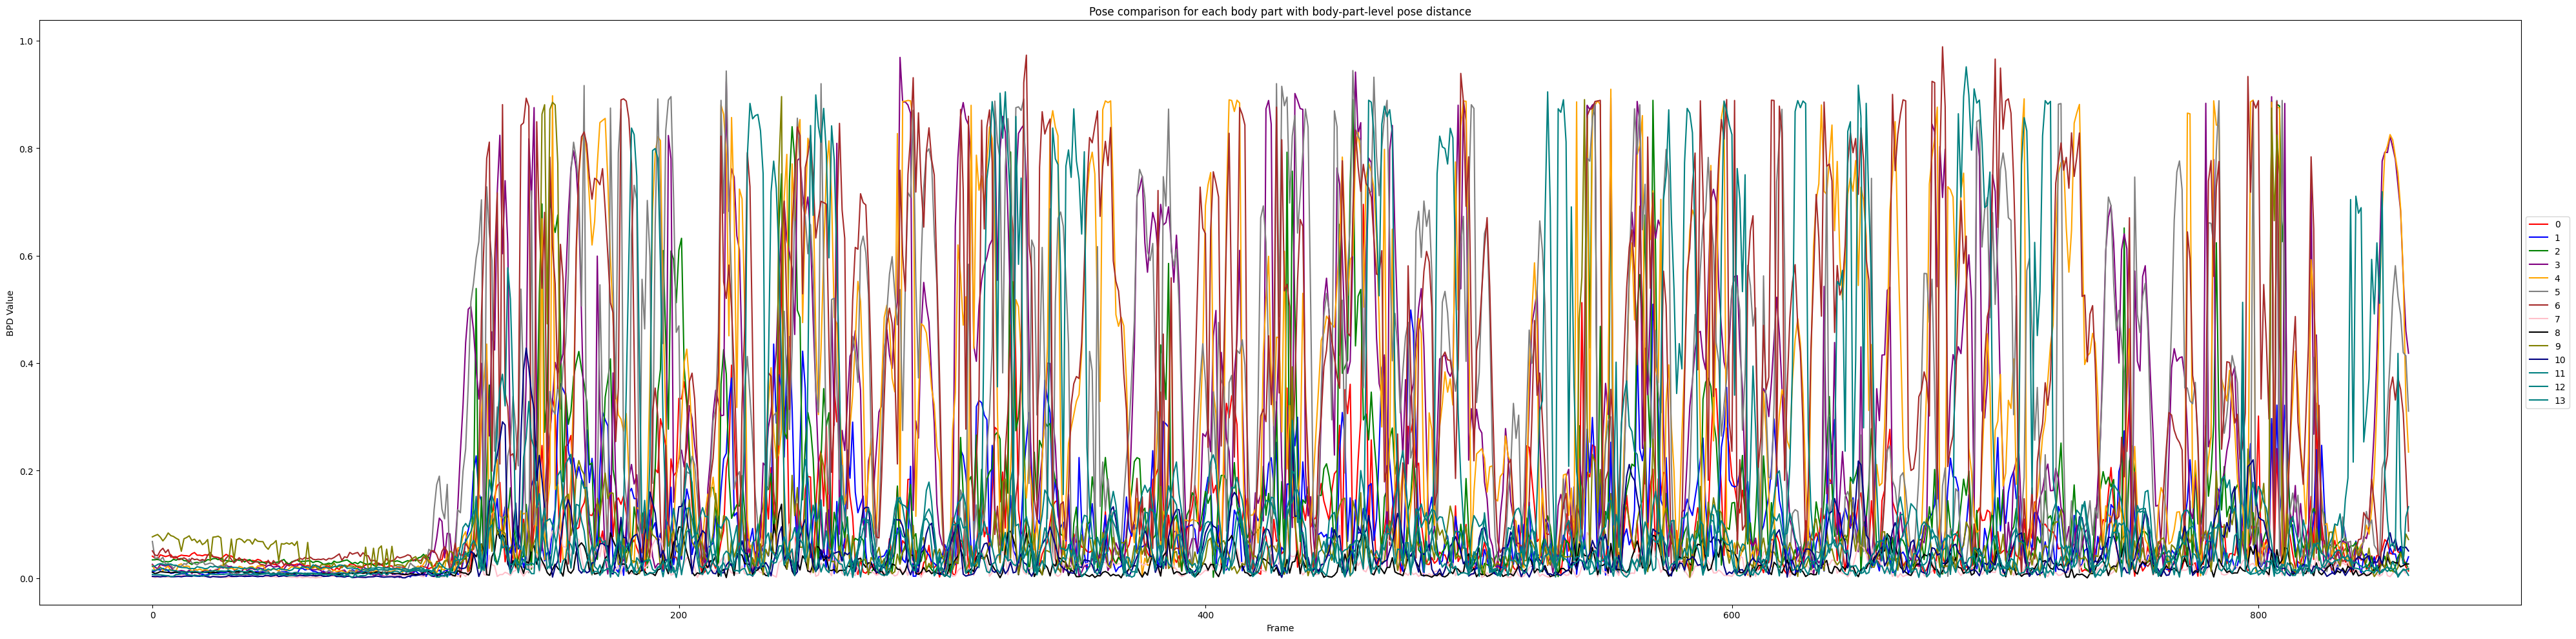

In [11]:
# Draw plot
import pandas as pd
import matplotlib.pyplot as plt

# plot the lines with different colors
plt.figure(figsize=(40,10))
plt.plot(saveBPD.index, saveBPD['0'], color='red', label='0')
plt.plot(saveBPD.index, saveBPD['1'], color='blue', label='1')
plt.plot(saveBPD.index, saveBPD['2'], color='green', label='2')
plt.plot(saveBPD.index, saveBPD['3'], color='purple', label='3')
plt.plot(saveBPD.index, saveBPD['4'], color='orange', label='4')
plt.plot(saveBPD.index, saveBPD['5'], color='grey', label='5')
plt.plot(saveBPD.index, saveBPD['6'], color='brown', label='6')
plt.plot(saveBPD.index, saveBPD['7'], color='pink', label='7')
plt.plot(saveBPD.index, saveBPD['8'], color='black', label='8')
plt.plot(saveBPD.index, saveBPD['9'], color='olive', label='9')
plt.plot(saveBPD.index, saveBPD['10'], color='navy', label='10')
plt.plot(saveBPD.index, saveBPD['11'], color='teal', label='11')
plt.plot(saveBPD.index, saveBPD['12'], color='teal', label='12')
plt.plot(saveBPD.index, saveBPD['13'], color='teal', label='13')


# set the title, x-axis label, y-axis label and legend
plt.title('Pose comparison for each body part with body-part-level pose distance')
plt.xlabel('Frame')
plt.ylabel('BPD Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save as pdf file
plt.tight_layout()
plt.savefig("BPDtest_swingTwo_.pdf")    # CHANGE THE FILE NAME!!!

# display the plot
plt.show()